# Dog Breed Identification

Classify 120 classes of dog breeds using subset of ImageNet images. This notebook utilizes pre-trained ResNet-101 weights, trained on the ImageNet images.  

#### Load Libraries

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
import psutil
print(psutil.cpu_percent())
print(psutil.virtual_memory()) 

0.0
svmem(total=33745100800, available=32583561216, percent=3.4, used=710311936, free=31751966720, active=1013104640, inactive=564768768, buffers=195035136, cached=1087787008, shared=1966080, slab=220184576)


#### Keep some handy functions here for memory management

In [5]:
import gc
gc.collect()

0

In [6]:
!nvidia-smi

Tue Jul 31 10:33:43 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.48                 Driver Version: 390.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 970     Off  | 00000000:26:00.0 Off |                  N/A |
| 26%   28C    P8    14W / 148W |     32MiB /  4043MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [7]:
!cat /proc/meminfo | grep Mem

MemTotal:       32954200 kB
MemFree:        31006068 kB
MemAvailable:   31818412 kB


In [8]:
torch.cuda.empty_cache()

## 1. First Look

In [9]:
PATH = "data/dogscats/dogBreed/"

In [10]:
os.listdir(PATH)

['.kaggle-cli', 'tmp', 'train', 'test', 'sample_submission.csv', 'labels.csv']

#### See an example of the training image

In [11]:
files = os.listdir(f'{PATH}train/')
files[:5]
print('number of train images:', len(files))
print('number of test images:', len(os.listdir(f'{PATH}test/')))

number of train images: 10222
number of test images: 10357


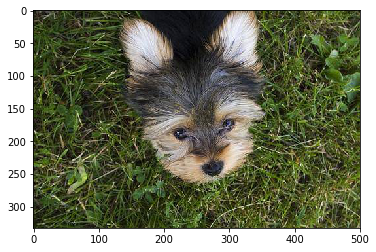

In [12]:
img = plt.imread(f'{PATH}train/{files[2]}')
plt.imshow(img);

In [13]:
label_df = pd.read_csv(f'{PATH}labels.csv')

#### Check distribution of labels

The classes are pretty evenly distributed.  Each classes has between 66 to 126 images.  

In [14]:
print(label_df['breed'].value_counts().nlargest(3))
print(label_df['breed'].value_counts().nsmallest(3))

scottish_deerhound    126
maltese_dog           117
afghan_hound          116
Name: breed, dtype: int64
eskimo_dog    66
briard        66
komondor      67
Name: breed, dtype: int64


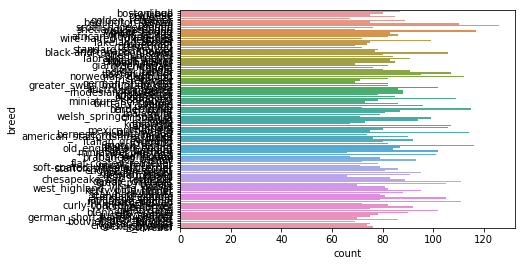

In [301]:
ax = sns.countplot(y="breed", data=label_df)

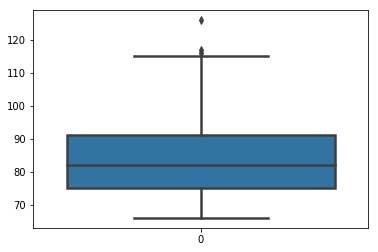

In [302]:
chart = label_df['breed'].value_counts()
ax = sns.boxplot(data=chart, linewidth=2.5)

## 2. Data Preparation

#### Create validation set indexes

In [303]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n, cv_idx = 0, val_pct = 0.2, seed = 10)

In [304]:
print('training set size:', n-len(val_idxs))
print('validation set size:', len(val_idxs))

training set size: 8178
validation set size: 2044


#### Get data

This method should be used when training image labels are given in an CSV file as opposed to sub-directories with label names.  Add suffix when labels don't contain the file end.

aug_tfms options: transforms_side_on, transforms_top_down

max_zoom: when doing data augmentation, randomly zoom but up to 1.1x

In [305]:
def get_data(arch, sz, bs):  # size, batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom = 1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv',
                                       test_name = 'test', num_workers = 4,
                                       val_idxs=val_idxs, suffix='.jpg',
                                       tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp')

Use a small image size (64) to get fast iteration.  If get cuda out of memory error, restart kernal, then change batchsize (bs) to something smaller.  But if image is similar to image net, do not start with sz 64, because it is so small that it would destroy the pre-trained weights.

In [20]:
sz = 128 # size of image
bs = 64 # mini-batch size.  Could be smaller depending on memory
arch = resnext101_64 # model architecture
#arch=resnext50

In [21]:
data = get_data(arch, sz, bs)

#### Examples of accessing the data object

In [22]:
print('train:{}, validation:{}, test:{}'.format(len(data.trn_ds), len(data.val_ds), len(data.test_ds)))

train:8178, validation:2044, test:10357


In [23]:
print('number of classes:{}\nsample classes:\n{}'.format(len(data.classes), data.classes[:5]))

number of classes:120
sample classes:
['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier']


In [24]:
fn = PATH+data.trn_ds.fnames[0];  # training set
fn

'data/dogscats/dogBreed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

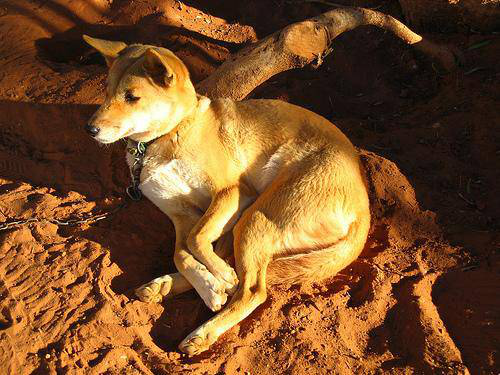

In [25]:
img = PIL.Image.open(fn)
img

#### Check Image Size

Check image size to see if they are around 224x224, 299x299.  Image net models are trained around these size, so no more pre-processing is needed

In [26]:
print(img.size)

(500, 375)


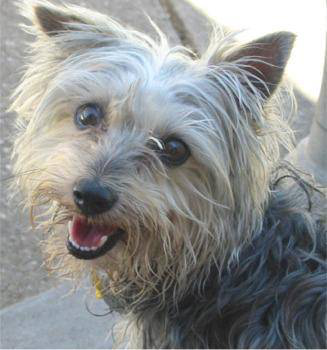

In [27]:
img = PIL.Image.open(PATH+data.val_ds.fnames[10]) # validation set
img

In [28]:
print(img.size)

(327, 350)


#### Create dictionary to map filename to size of file

In [29]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [30]:
row_sz, col_sz = list(zip(*size_d.values())) 
row_sz[0], col_sz[0]

(500, 375)

In [31]:
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)
row_sz[:5]

array([500, 500, 400, 500, 500])

(array([ 144.,  603., 1318., 1180., 4596.,  128.,   73.,   60.,   12.,   11.]),
 array([ 97. , 186.3, 275.6, 364.9, 454.2, 543.5, 632.8, 722.1, 811.4, 900.7, 990. ]),
 <a list of 10 Patch objects>)

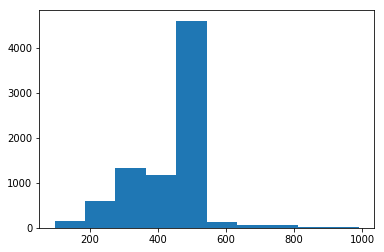

In [32]:
plt.hist(row_sz[row_sz<1000])

(array([ 238.,  726., 2235., 2971., 1792.,   92.,   24.,   32.,    6.,    9.]),
 array([102. , 190.2, 278.4, 366.6, 454.8, 543. , 631.2, 719.4, 807.6, 895.8, 984. ]),
 <a list of 10 Patch objects>)

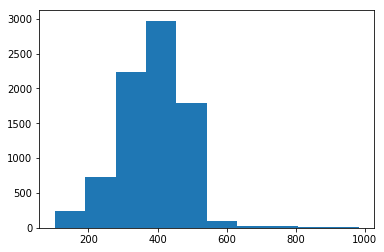

In [33]:
plt.hist(col_sz[col_sz<1000])

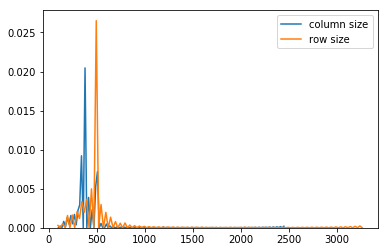

In [34]:
sns.kdeplot(col_sz, bw=0.5,label="column size")
sns.kdeplot(row_sz, bw=0.5,label="row size")

## 3. Model

1. precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

In [35]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
#learn = ConvLearner.pretrained(arch, data, metrics=metrics)

100%|██████████| 162/162 [00:58<00:00,  2.76it/s]


#### Use `lr_find()` to find highest learning rate where loss is still clearly improving

In [42]:
lrf=learn.lr_find()

 81%|████████▏ | 104/128 [00:01<00:00, 99.35it/s, loss=2.95]


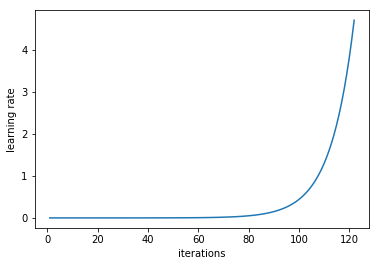

In [43]:
learn.sched.plot_lr()

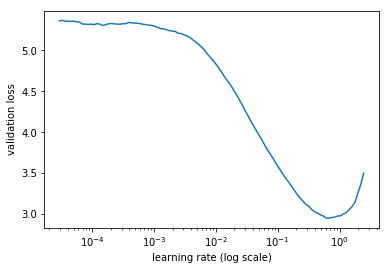

In [44]:
learn.sched.plot()

#### Train last layer from precomputed activations for 1-2 epochs

In [53]:
lr = 1e-2

In [54]:
learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      1.680584   1.06319    0.766145  
    1      1.070282   0.826998   0.790607                    



[array([0.827]), 0.7906066544368542]

#### Train last layer with data augmentation (i.e. precompute = False) for 2-3 epoches with cycle_len = 1

learn.precompute=False

In [55]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.836469   0.768357   0.793542  
    1      0.752503   0.744017   0.792074                     
    2      0.672503   0.719117   0.799413                     



[array([0.71912]), 0.799412916667774]

If validation does not improve, do not need to continue to train the last layer.  Try training earlier layers

#### Unfreeze all layers

In [56]:
learn.unfreeze()

#### Fine-tuning and differential learning rate annealing

Set earlier layers to 3x to 10x lower learning rate than next higher layer.   use this learning rate lr = np.array([lr/10, lr/3, lr]) if image is very different form imageNet.  You want to learn earlier layers more

In [57]:
lrf=learn.lr_find()

 91%|█████████▏| 117/128 [00:41<00:03,  2.81it/s, loss=2.66] 

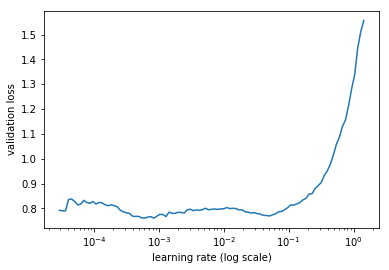

In [58]:
learn.sched.plot()

In [59]:
lr = 1e-2
lrs=np.array([1e-4,1e-3,1e-2])

#lr = 1e-2
#lr = np.array([lr/10, lr/3, lr]) 

The number of epochs between resetting the learning rate is set by cycle_len, and the number of times this happens is refered to as the number of cycles.  cycle_mult is multiplying the cycle_len by a factor each time.  cycle_mult=2,  The first cycle is 1 epoch, the 2nd cycle is 2 epochs, the 3rd cycle is 4 epochs.   

#### Train full network with cycle_mult = 2 until over-fitting

If overfits quickly (due to more complicated architecture), then do not do cycle_mult = 2.  Just do learn.fit(lr, 3, cycle_len = 1)

In [60]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2) 

epoch      trn_loss   val_loss   accuracy                    
    0      0.761159   0.696464   0.798924  
    1      0.757928   0.692069   0.797456                    
    2      0.654976   0.677641   0.800881                    
    3      0.703305   0.684882   0.798434                    
    4      0.628717   0.685085   0.800881                    
    5      0.570066   0.677891   0.801859                    
    6      0.535058   0.677836   0.803816                    


[array([0.67784]), 0.8038160477832339]

See effect of cycle_mult 

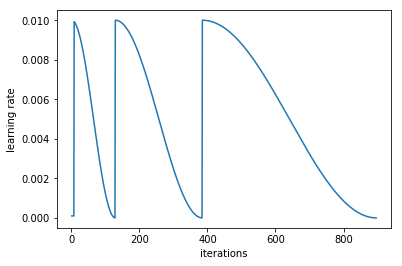

In [61]:
learn.sched.plot_lr()

#### Check performance at first iteration of trining the last layer, and prior layers.  Check validation with data augmentation

In [62]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [66]:
accuracy_np(probs, y)

0.8145792563600783

In [67]:
preds = np.argmax(probs, axis=1)

In [68]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

Text(0.5,33,'Predicted label')

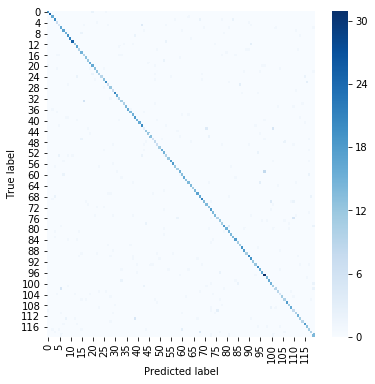

In [69]:
plt.figure(figsize = (6, 6))
#ax = sns.heatmap(cm, cmap="PiYG", annot=True)
#ax = sns.heatmap(cm, cmap="Blues", xticklabels=data.classes, yticklabels=data.classes)
ax = sns.heatmap(cm, cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [63]:
print(psutil.cpu_percent())
print(psutil.virtual_memory()) 

7.6
svmem(total=33745100800, available=29531693056, percent=12.5, used=3729666048, free=22526951424, active=5614673920, inactive=4743438336, buffers=237420544, cached=7251062784, shared=8249344, slab=576745472)


####  Increase Size

In [73]:
sz = 299
learn.set_data(get_data(arch,sz,bs))
learn.freeze()

If validation loss is lower than training loss, that means underfitting, so maybe cycle_len is too short.  It finds a gradient that is better, but it pops out, never never get a chance to zoom in, so can increase cycle_mult to 2 to give it more time.  The first cycle is 1 epoch, the 2nd cycle is 2 epochs, the 3rd cycle is 4 epochs.  The goal is to have training loss and validation loss to be about the same.  

 89%|████████▉ | 114/128 [03:41<00:27,  1.94s/it, loss=1.41] 

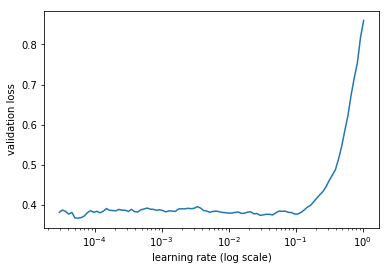

In [75]:
lrf=learn.lr_find()
learn.sched.plot()

In [76]:
learn.save('dogbreed_299')

#### Train final layer with bigger image size

In [77]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.369835   0.275653   0.920744  
    1      0.327167   0.250669   0.928082                    
    2      0.289783   0.243215   0.927593                    


[array([0.24321]), 0.9275929551068584]

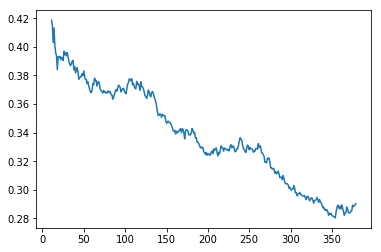

In [83]:
learn.sched.plot_loss()

In [78]:
learn.save('dogbreed_299')

In [79]:
!cat /proc/meminfo | grep Mem

MemTotal:       32954200 kB
MemFree:        21786668 kB
MemAvailable:   28627884 kB


In [80]:
gc.collect()

9495

#### Train final layer with cycle_mult = 2 

In [84]:
learn.fit(lr, 3, cycle_len=1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.27754    0.236625   0.927104  
    1      0.24065    0.22591    0.92955                     
    2      0.221504   0.222477   0.930528                    
    3      0.216734   0.220092   0.933464                    
    4      0.196755   0.211759   0.931018                    
    5      0.169474   0.212734   0.930039                    
    6      0.16482    0.210548   0.930039                    


[array([0.21055]), 0.9300391390598917]

In [87]:
learn.save('dogbreed_299')
#learn.load('dogbreed_299')

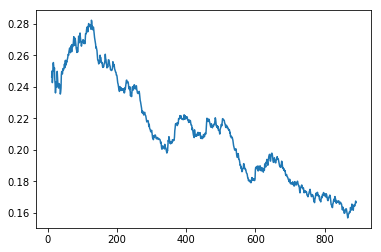

In [88]:
learn.sched.plot_loss()

In [90]:
gc.collect()

7138

In [18]:
!cat /proc/meminfo | grep Mem

MemTotal:       32954200 kB
MemFree:        23263936 kB
MemAvailable:   30108500 kB


#### Unfreeze layer and train. Train full network with cycle_mult=2 until over-fitting

Reload data due to memory.  Reduce batch size.
RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [306]:
sz = 299 # size of image
bs = 64 # mini-batch size.  Could be smaller depending on memory
arch = resnext101_64 # model architecture
#arch=resnext50

In [307]:
data = get_data(arch, sz, bs)

In [308]:
learn = ConvLearner.pretrained(arch, data)

In [309]:
learn.load('dogbreed_299')

#### Not enough memory to train on unfreeze layer with 299 size

In [19]:
#lrs=np.array([1e-4,1e-3,1e-2])

In [ ]:
#learn.unfreeze()
#learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
#learn.fit(lrs, 1, cycle_len=1, cycle_mult=2)
#learn.save('dogbreed_299_F')

#### Run a couple cycles more to see if it gets better

In [ ]:
#learn.fit(1e-2, 1, cycle_len=2)

In [ ]:
#learn.save('dogbreed_299')

## 4. Model Evaluation

#### Test time augmentation, or just TTA.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's TTA() method.

In [310]:
log_preds,y = learn.TTA()

In [311]:
log_preds.shape

(5, 2044, 120)

In [312]:
probs = np.mean(np.exp(log_preds),axis = 0)

In [313]:
probs.shape

(2044, 120)

In [314]:
print('log_preds:',log_preds[0])
print('probs:', probs[0])
print('y:', y[0])

log_preds: [[-13.8432  -15.13389 -11.839   ... -13.43512 -15.07999 -10.91167]
 [-13.98665 -13.3567  -13.34188 ... -12.03267 -10.92203 -14.07066]
 [-11.59006  -9.77119 -14.13903 ... -10.68653  -0.08549 -12.13402]
 ...
 [-10.71893  -9.06096 -12.60906 ... -13.46766 -12.24976 -11.82568]
 [-15.3454  -12.58929 -18.46281 ... -17.53697 -18.01846 -14.56256]
 [-14.75881 -11.1725  -11.54906 ... -10.19963 -11.97619  -9.86901]]
probs: [0.      0.      0.00001 0.      0.      0.      0.      0.00002 0.00001 0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.99819 0.      0.00007 0.      0.      0.      0.00001
 0.      0.00009 0.      0.00001 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.00001 0.      0.      0.      0.00124 0.      0.      0.      0.      0.      0.
 0.      0.00002 0.      0.      0.      0.      0.      0.      0.      0.00001 0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.00001 0.  

#### Accuracy

In [315]:
print("accuracy:", accuracy_np(probs, y))
print("log_loss:", metrics.log_loss(y, probs))

accuracy: 0.9393346379647749
log_loss: 0.2085074285947679


#### Confusion Matrix

Text(0.5,33,'Predicted label')

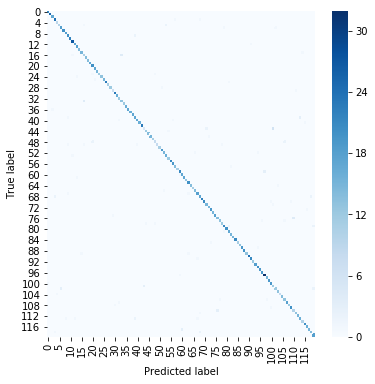

In [316]:
preds = np.argmax(probs, axis=1)
cm = confusion_matrix(y, preds)
plt.figure(figsize = (6, 6))
#ax = sns.heatmap(cm, cmap="PiYG", annot=True)
#ax = sns.heatmap(cm, cmap="Blues", xticklabels=data.classes, yticklabels=data.classes)
ax = sns.heatmap(cm, cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')

#### Summary Table

In [317]:
classes = pd.DataFrame(data = data.classes, columns = ['class'])

In [318]:
files = pd.DataFrame(data = data.val_ds.fnames, columns=['fileName'])

In [319]:
perf = pd.DataFrame()
perf['y'] = y
perf['pred'] = preds
perf['correct'] = perf['y']==perf['pred']
perf['prob_y'] = probs[perf.index, y[perf.index]]  #  column number is y[perf.index]
perf['prob_pred'] = probs[perf.index, preds[perf.index]] # preds = np.argmax(probs, axis=1)
perf['y_class'] = perf["y"].map(classes['class'])
perf['pred_class'] = perf["pred"].map(classes['class'])
perf['prob_diff'] = perf['prob_pred']-perf['prob_y']
perf['y_filename'] = perf.index.map(files['fileName'])

In [320]:
perf['correct'].value_counts(normalize = True)

True     0.939335
False    0.060665
Name: correct, dtype: float64

#### Wrongly Classified Samples

In [321]:
wrong = perf[perf['correct'] == False]

In [322]:
wrong = wrong.sort_values(by = 'prob_diff', ascending= False)

In [323]:
wrong.head()

,y,pred,correct,prob_y,prob_pred,y_class,pred_class,prob_diff,y_filename
82,43,71,False,0.003262,0.984605,eskimo_dog,malamute,0.981343,train/08e99ed86b0ce429fef52a8ca33e1551.jpg
1693,78,44,False,0.002540,0.982776,newfoundland,flat-coated_retriever,0.980236,train/d3781e17b2296322306eda8141f6de86.jpg
1762,113,39,False,0.013861,0.985980,walker_hound,english_foxhound,0.972119,train/dcf58c0dac2664e94f476fdc56aa7ffc.jpg
1163,9,39,False,0.008092,0.978259,beagle,english_foxhound,0.970167,train/8fbd1187590a9b65878e467e96705637.jpg
699,53,11,False,0.003254,0.960699,greater_swiss_mountain_dog,bernese_mountain_dog,0.957444,train/54e86ccdccd89c2b15d712c61b9460a9.jpg


#### Most commonly mistaken combinations

In [354]:
temp = wrong.groupby(['y_class', 'pred_class']).size().reset_index()

In [355]:
temp = temp.sort_values(by = 0, ascending = False)

In [357]:
temp.head(10)

,y_class,pred_class,0
26,eskimo_dog,siberian_husky,6
18,collie,border_collie,4
10,border_collie,collie,4
53,miniature_poodle,toy_poodle,4
39,irish_wolfhound,scottish_deerhound,3
83,whippet,italian_greyhound,3
68,siberian_husky,eskimo_dog,3
69,silky_terrier,australian_terrier,3
77,toy_poodle,miniature_poodle,3
21,english_foxhound,walker_hound,3


#### Most commonly mistaken pairs

In [415]:
temp2 = temp.merge(temp, left_on = 'pred_class', right_on = 'y_class', how = 'left')
temp2['total'] = temp2['0_x']+ temp2['0_y']

In [416]:
pairs = temp2[(temp2['y_class_x'] == temp2['pred_class_y']) & (temp2['y_class_x'] > temp2['pred_class_x']) ]
pairs = pairs[['y_class_x', 'pred_class_x', 'total']]
pairs.columns = ['class_1', 'class_2', 'total']

In [417]:
pairs

,class_1,class_2,total
1,collie,border_collie,8.0
7,siberian_husky,eskimo_dog,9.0
9,silky_terrier,australian_terrier,4.0
11,toy_poodle,miniature_poodle,7.0
24,wire-haired_fox_terrier,lakeland_terrier,4.0
25,walker_hound,english_foxhound,5.0
30,lakeland_terrier,airedale,3.0
44,norwich_terrier,norfolk_terrier,3.0
51,scottish_deerhound,irish_wolfhound,4.0
54,standard_schnauzer,miniature_schnauzer,2.0


In [418]:
notPairs = temp2[(temp2['y_class_x'] != temp2['pred_class_y']) & (temp2['y_class_x'] > temp2['pred_class_x'])]
notPairs = notPairs[['y_class_x', 'pred_class_x', '0_x']].drop_duplicates()
notPairs.columns = ['class_1', 'class_2', 'total']

In [419]:
notPairs.head()

,class_1,class_2,total
2,collie,border_collie,4
6,whippet,italian_greyhound,3
8,siberian_husky,eskimo_dog,3
10,silky_terrier,australian_terrier,3
18,giant_schnauzer,bouvier_des_flandres,2


In [420]:
all_combos = pairs.append(notPairs)
all_combos = all_combos.drop_duplicates(['class_1', 'class_2'], keep ='first')
all_combos = all_combos.sort_values(by = ['total', 'class_1'], ascending = False)
all_combos.head(10)

,class_1,class_2,total
7,siberian_husky,eskimo_dog,9.0
1,collie,border_collie,8.0
11,toy_poodle,miniature_poodle,7.0
25,walker_hound,english_foxhound,5.0
24,wire-haired_fox_terrier,lakeland_terrier,4.0
9,silky_terrier,australian_terrier,4.0
51,scottish_deerhound,irish_wolfhound,4.0
6,whippet,italian_greyhound,3.0
44,norwich_terrier,norfolk_terrier,3.0
30,lakeland_terrier,airedale,3.0


#### View images of wronly classified samples

In [237]:
def load_img_id(idx): 
    file = data.val_ds.fnames[idx]
    return np.array(PIL.Image.open(PATH+file))
    #return (PIL.Image.open(PATH+file))

In [285]:
def sample_img_pred_class(idx):
    file = perf.loc[perf['y'] == perf.loc[idx, 'pred'], 'y_filename'].head(1).values[0]
    return np.array(PIL.Image.open(PATH+file))
    #return (PIL.Image.open(PATH+file))

In [258]:
def plot_val_with_title(idx):
    imgs = [load_img_id(idx), sample_img_pred_class(idx)]
    print(perf.iloc[idx])
    title = ['Actual', 'Sample Predicted Class']
    return plots(imgs, rows=1, titles = title, figsize=(8,4)) # (16, 8)

In [259]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

y                                                     78
pred                                                  44
correct                                            False
prob_y                                        0.00048615
prob_pred                                       0.995155
y_class                                     newfoundland
pred_class                         flat-coated_retriever
prob_diff                                       0.994669
y_filename    train/d3781e17b2296322306eda8141f6de86.jpg
Name: 1693, dtype: object
y                                                     43
pred                                                  71
correct                                            False
prob_y                                        0.00477851
prob_pred                                       0.985331
y_class                                       eskimo_dog
pred_class                                      malamute
prob_diff                                       0.980553
y_fil

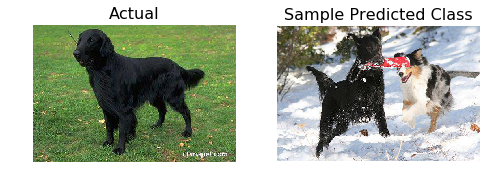

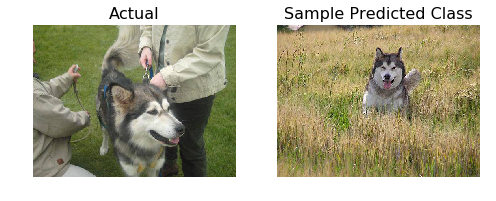

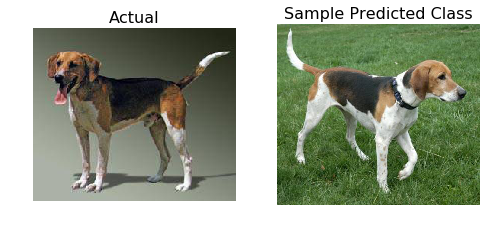

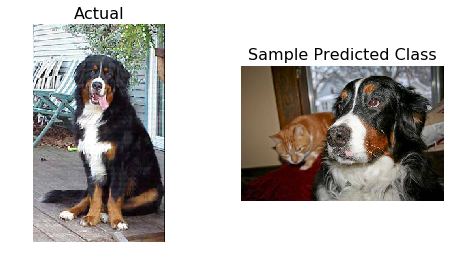

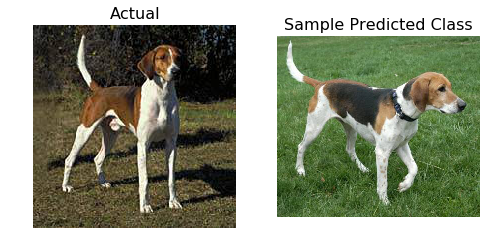

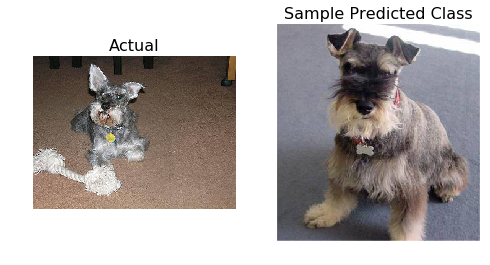

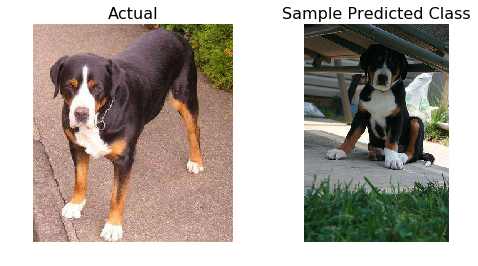

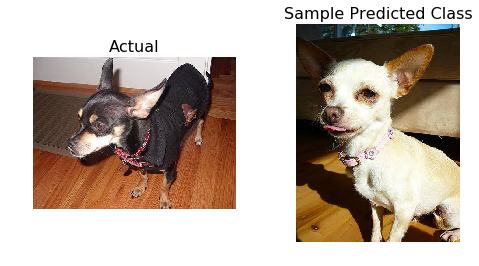

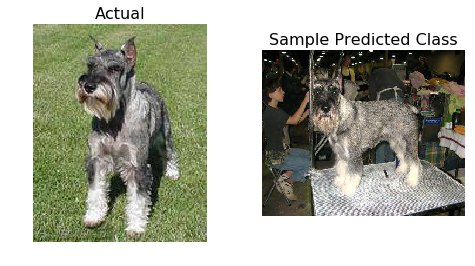

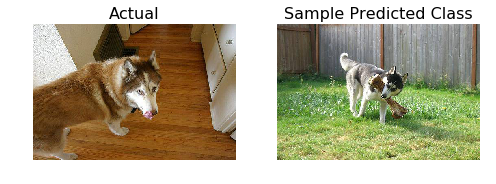

In [286]:
for x in wrong.index[:10]:
    plot_val_with_title(x)

y                                                    113
pred                                                  39
correct                                            False
prob_y                                         0.0150876
prob_pred                                       0.984691
y_class                                     walker_hound
pred_class                              english_foxhound
prob_diff                                       0.969603
y_filename    train/dcf58c0dac2664e94f476fdc56aa7ffc.jpg
Name: 1762, dtype: object


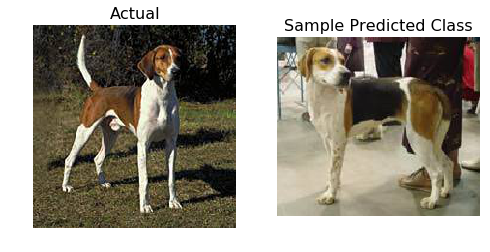

In [263]:
plot_val_with_title(1762)

## 5. Make Predictions on Test Set

#### Check if test set is available

In [33]:
(learn.data.test_dl != None)

True

#### Make predictions on augmented test data

In [35]:
log_mypreds = learn.predict(is_test=True)

In [46]:
log_mypreds.shape

(10357, 120)

#### Get Prediction Probability

In [53]:
testprobs = np.exp(log_mypreds)

In [56]:
testprobs[0]

array([0.00193, 0.00006, 0.00004, 0.00001, 0.00001, 0.00002, 0.00021, 0.00001, 0.00002, 0.00002, 0.00001,
       0.00023, 0.00004, 0.00002, 0.     , 0.00004, 0.0002 , 0.00003, 0.00004, 0.00008, 0.00005, 0.00001,
       0.00005, 0.00021, 0.00001, 0.00001, 0.00003, 0.00001, 0.     , 0.00002, 0.00002, 0.00003, 0.00016,
       0.00011, 0.00001, 0.00009, 0.00001, 0.     , 0.00002, 0.00001, 0.00007, 0.00004, 0.00004, 0.00001,
       0.00007, 0.00001, 0.     , 0.00004, 0.00003, 0.00001, 0.00002, 0.     , 0.00004, 0.00001, 0.00001,
       0.     , 0.00001, 0.     , 0.     , 0.     , 0.00001, 0.00173, 0.00008, 0.00001, 0.00002, 0.00001,
       0.00001, 0.00001, 0.     , 0.00001, 0.05935, 0.00004, 0.     , 0.00204, 0.00001, 0.00001, 0.00005,
       0.00093, 0.00008, 0.00016, 0.00002, 0.00001, 0.00011, 0.     , 0.0004 , 0.00202, 0.00003, 0.00025,
       0.00004, 0.     , 0.00001, 0.00002, 0.00002, 0.00002, 0.00001, 0.00001, 0.00001, 0.00001, 0.00004,
       0.00022, 0.9206 , 0.00005, 0.00071, 0.0

#### Check the format of the submission file

In [78]:
submission = pd.read_csv(f'{PATH}sample_submission.csv')

In [79]:
submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [80]:
submission.shape

(10357, 121)

#### Create submission file

In [107]:
mySubmission = pd.DataFrame(data=testprobs, columns= data.classes)

In [108]:
mySubmission.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,1.928607e-03,5.844792e-05,4.264433e-05,0.000005,1.376587e-05,2.289091e-05,2.142812e-04,5.152329e-06,1.564570e-05,1.825465e-05,...,2.433814e-04,7.307857e-05,3.802372e-05,1.594726e-05,0.000076,0.000003,7.022511e-05,0.000013,0.000018,1.850137e-03
1,5.550667e-07,1.505112e-07,5.050581e-07,0.000002,1.378576e-06,6.005750e-05,1.211645e-05,2.234357e-07,7.757437e-07,5.698408e-07,...,9.384414e-07,2.826056e-06,5.009590e-07,5.152511e-06,0.000001,0.000004,2.916354e-06,0.000004,0.000015,7.219770e-07
2,1.159749e-02,1.448383e-04,4.148578e-04,0.000069,4.355958e-05,3.723953e-06,3.226979e-01,3.831054e-05,3.891110e-05,1.935836e-04,...,1.116581e-04,6.313931e-05,8.654974e-06,2.354163e-05,0.000159,0.000019,2.317965e-04,0.000158,0.001231,3.541971e-01
3,6.256174e-07,7.097809e-06,1.561773e-06,0.000010,2.831873e-06,8.851328e-06,6.291412e-06,2.253815e-05,6.526523e-06,3.164794e-06,...,1.647953e-05,7.567070e-04,8.707456e-06,7.090567e-07,0.000003,0.000002,6.684504e-07,0.000006,0.000002,8.654303e-05
4,1.495751e-06,7.159389e-06,5.521865e-05,0.000009,9.198840e-07,8.825489e-07,5.404569e-07,8.529145e-07,4.946118e-06,5.209776e-07,...,1.629497e-04,1.521778e-07,2.262785e-07,1.003260e-06,0.000001,0.000003,1.012207e-04,0.000002,0.000002,1.172572e-06


In [103]:
data.test_ds.fnames[0]

'test/7e739331d854dd7462c853a21f378387.jpg'

In [109]:
mySubmission.insert(0, 'id', data.test_ds.fnames, allow_duplicates=False) # insert to location 0 

In [111]:
mySubmission['id'] = mySubmission['id'].str.replace('test/', '')

In [112]:
mySubmission['id'] = mySubmission['id'].str.replace('.jpg', '')

In [113]:
mySubmission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,7e739331d854dd7462c853a21f378387,1.928607e-03,5.844792e-05,4.264433e-05,0.000005,1.376587e-05,2.289091e-05,2.142812e-04,5.152329e-06,1.564570e-05,...,2.433814e-04,7.307857e-05,3.802372e-05,1.594726e-05,0.000076,0.000003,7.022511e-05,0.000013,0.000018,1.850137e-03
1,94b3aaec44d9bb38ab0d6cdb15ce769e,5.550667e-07,1.505112e-07,5.050581e-07,0.000002,1.378576e-06,6.005750e-05,1.211645e-05,2.234357e-07,7.757437e-07,...,9.384414e-07,2.826056e-06,5.009590e-07,5.152511e-06,0.000001,0.000004,2.916354e-06,0.000004,0.000015,7.219770e-07
2,a9ee25d56bd8dbb5b7f340338901a879,1.159749e-02,1.448383e-04,4.148578e-04,0.000069,4.355958e-05,3.723953e-06,3.226979e-01,3.831054e-05,3.891110e-05,...,1.116581e-04,6.313931e-05,8.654974e-06,2.354163e-05,0.000159,0.000019,2.317965e-04,0.000158,0.001231,3.541971e-01
3,fddaf71e6d20393e50ef962daf60d7a6,6.256174e-07,7.097809e-06,1.561773e-06,0.000010,2.831873e-06,8.851328e-06,6.291412e-06,2.253815e-05,6.526523e-06,...,1.647953e-05,7.567070e-04,8.707456e-06,7.090567e-07,0.000003,0.000002,6.684504e-07,0.000006,0.000002,8.654303e-05
4,2760e039981df1fb36520cd0439ebf24,1.495751e-06,7.159389e-06,5.521865e-05,0.000009,9.198840e-07,8.825489e-07,5.404569e-07,8.529145e-07,4.946118e-06,...,1.629497e-04,1.521778e-07,2.262785e-07,1.003260e-06,0.000001,0.000003,1.012207e-04,0.000002,0.000002,1.172572e-06


In [114]:
mySubmission.to_csv('mySubmission.csv',  header=True, index= False)

In [115]:
### Public Leaderboard Log_Loss: 0.21177

In [ ]:
#!kaggle competitions submit -c dog-breed-identification -f mySubmission.csv  -m "resnet101"